# Bout, Stim, and Duration Post Hoc Analysis

In [57]:
import joblib
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
import time
from tkinter import *
import tkinter as tk
from tkinter import filedialog
from tqdm import tqdm
from tqdm import notebook
import itertools
import math
import seaborn as sns
import statistics 
from collections import OrderedDict
import csv

In [58]:
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
infiles = filedialog.askopenfilename(multiple=True, title='load posthoc-predictions.npy')

%gui tk

In [59]:
infiles

('Z:/KayCei/AD10-D1/VIDEOS/061523-rt bilateral/VideoOutputCamera 0-15062023-114036_posthoc-predictions.npy',)

In [60]:
Random_List = [] #creates a array known as random list 
for f in range(len(infiles)):
    arr = np.load(infiles[f])
    Random_List.extend(arr) 

# Total Time of Video in deciseconds

In [61]:
print('This video is ', len(Random_List), ' deciseconds, which is', (len(Random_List)/600), 'minutes' )
print()
#print(Random_List)

This video is  39918  deciseconds, which is 66.53 minutes



# This is to remove any time period after 65 minutes

In [62]:
length_of_session = (int(input("How long was the session in minutes?"))) * 600
print(length_of_session)
Random_List = Random_List[:(length_of_session)]

How long was the session in minutes?65
39000


In [63]:
print('This video is ', len(Random_List), ' deciseconds, which is', (len(Random_List)/600), 'minutes' )
print()
#print(Random_List)

This video is  39000  deciseconds, which is 65.0 minutes



# Creates an array with tuples of (behavior type, stim count) 

In [64]:
behavior_type_and_duration = [] #this section of code creates a array with tuples that show (behavior type, duration(aka stim cont))
current_value = Random_List[0]
count = 0
for value in Random_List:
    if value==current_value:
        count += 1
    else:
        behavior_type_and_duration.append((current_value, count))
        current_value = value
        count = 1

# Append the final (current_value, count) pair outside the loop
behavior_type_and_duration.append((current_value, count))

# Make a copy of the original behavior_type_and_duration list
original_behavior_type_and_duration = list(behavior_type_and_duration)


In [65]:
#print(original_behavior_type_and_duration)

# Filtering Out Based on 3 Frame Rate

In [66]:
behavior_type_and_duration = [(behavior, duration) for behavior, duration in behavior_type_and_duration if duration >= 3]

In [67]:
print(behavior_type_and_duration)

[(5.0, 44), (3.0, 6), (5.0, 3), (5.0, 3), (5.0, 6), (3.0, 5), (3.0, 3), (5.0, 5), (3.0, 12), (5.0, 64), (2.0, 20), (5.0, 7), (5.0, 8), (5.0, 3), (5.0, 4), (2.0, 3), (5.0, 4), (2.0, 3), (5.0, 5), (5.0, 9), (5.0, 6), (5.0, 6), (2.0, 3), (5.0, 4), (5.0, 3), (5.0, 5), (0.0, 3), (5.0, 12), (2.0, 3), (5.0, 4), (5.0, 4), (5.0, 3), (2.0, 23), (5.0, 3), (5.0, 6), (5.0, 4), (5.0, 21), (2.0, 15), (2.0, 3), (5.0, 3), (2.0, 3), (5.0, 8), (5.0, 10), (2.0, 5), (5.0, 3), (5.0, 16), (2.0, 5), (5.0, 10), (5.0, 12), (5.0, 14), (1.0, 6), (5.0, 3), (2.0, 3), (5.0, 3), (5.0, 4), (2.0, 7), (5.0, 32), (5.0, 34), (5.0, 115), (5.0, 20), (5.0, 10), (5.0, 156), (1.0, 5), (5.0, 19), (5.0, 8), (5.0, 19), (5.0, 13), (5.0, 170), (2.0, 3), (5.0, 13), (2.0, 13), (5.0, 11), (2.0, 6), (2.0, 4), (5.0, 20), (5.0, 5), (2.0, 7), (2.0, 21), (1.0, 4), (5.0, 3), (5.0, 20), (5.0, 7), (2.0, 8), (5.0, 10), (5.0, 4), (5.0, 6), (5.0, 3), (1.0, 3), (2.0, 6), (5.0, 3), (2.0, 17), (5.0, 7), (3.0, 14), (5.0, 7), (5.0, 14), (0.0, 5), (5.

In [68]:
desired_order = {
    0.0: "Left Turns",
    1.0: "Right Turns",
    2.0: "Locomotion",
    3.0: "Face Groom",
    4.0: "All Other Groom",
    5.0: "All Other",
}


In [69]:
indexed_behavior_type_and_duration = []
index_position = None
for behavior_name, behavior_duration in original_behavior_type_and_duration:
    if behavior_name in desired_order:
        if index_position is None:
            index_position = behavior_duration
        else:
            index_position += behavior_duration
        indexed_behavior_type_and_duration.append(((behavior_name, behavior_duration), index_position))

# Print the results
#for (behavior_name, behavior_duration), index_pos in indexed_behavior_type_and_duration:
    #print("Index:", index_pos, "- Behavior:", behavior_labels[behavior_name], "- Stim Count:", behavior_duration)

## Dictionary Mappings 

In [70]:
behavior_labels = {
    0.0: "Left Turns",
    1.0: "Right Turns",
    2.0: "Locomotion",
    3.0: "Face Groom",
    4.0: "All Other Groom",
    5.0: "All Other",
}

#  Total Bouts of Every Behavior in a Session

In [71]:

# Create a dictionary to store the number of bouts for each behavior
behavior_bouts = {}
for behavior_name, behavior_duration in behavior_type_and_duration:
    behavior_name_str = desired_order.get(behavior_name, "Unknown Behavior")
    if behavior_name_str not in behavior_bouts:
        behavior_bouts[behavior_name_str] = 0  # Initialize the counter for each behavior to zero
    behavior_bouts[behavior_name_str] += 1  # Increment the counter for the current behavior

# Print the results in the desired order
for behavior_name in desired_order.values():
    if behavior_name in behavior_bouts:
        count = behavior_bouts[behavior_name]
        print(count, "bout(s) of", behavior_name)
keys_list = behavior_bouts.keys()
print(keys_list)

102 bout(s) of Left Turns
72 bout(s) of Right Turns
385 bout(s) of Locomotion
166 bout(s) of Face Groom
232 bout(s) of All Other Groom
1221 bout(s) of All Other
dict_keys(['All Other', 'Face Groom', 'Locomotion', 'Left Turns', 'Right Turns', 'All Other Groom'])


In [72]:
# Define the range limits for index position
min_index_position = 3000
max_index_position = 21000

# Filter behavior_type_and_duration to remove behaviors with duration less than 3
behavior_type_and_duration_filtered = [(behavior, duration) for behavior, duration in behavior_type_and_duration if duration >= 3]

# Create a dictionary to store the number of bouts for each behavior type in the desired range
behavior_bouts_in_range = {}

for (behavior_name, behavior_duration), index_pos in indexed_behavior_type_and_duration:
    # Check if the behavior has a duration of 3 or more
    if behavior_duration >= 3:
        # Check if the index position falls within the desired range
        if min_index_position <= index_pos <= max_index_position:
            behavior_name_str = desired_order.get(behavior_name, "Unknown Behavior")
            if behavior_name_str not in behavior_bouts_in_range:
                behavior_bouts_in_range[behavior_name_str] = 0  # Initialize the counter for each behavior to zero
            behavior_bouts_in_range[behavior_name_str] += 1  # Increment the counter for the current behavior

# Print the results of bouts for each behavior type within the range
for behavior_name in desired_order.values():
    if behavior_name in behavior_bouts_in_range:
        count = behavior_bouts_in_range[behavior_name]
        print(count, "bout(s) of", behavior_name, "during 30 minute stimulation block")


53 bout(s) of Left Turns during 30 minute stimulation block
36 bout(s) of Right Turns during 30 minute stimulation block
172 bout(s) of Locomotion during 30 minute stimulation block
69 bout(s) of Face Groom during 30 minute stimulation block
112 bout(s) of All Other Groom during 30 minute stimulation block
579 bout(s) of All Other during 30 minute stimulation block


In [73]:
# Initialize dictionaries to store total duration and count for each behavior
behavior_duration_dict = {}
behavior_count_dict = {}

# Loop through the behavior_type_and_duration list
for x in behavior_type_and_duration:
    behavior_type = x[0]
    duration = x[1]
    
    # Check if the behavior_type already exists in the dictionaries
    if behavior_type in behavior_duration_dict:
        behavior_duration_dict[behavior_type] += duration
        behavior_count_dict[behavior_type] += 1
    else:
        behavior_duration_dict[behavior_type] = duration
        behavior_count_dict[behavior_type] = 1
my_keys=behavior_duration_dict.keys()
print(my_keys)

# Initialize a dictionary to store the average duration for each behavior
behavior_average_duration_dict = {}

# Calculate the average duration for each behavior and store it in the dictionary
for behavior_type, total_duration in behavior_duration_dict.items():
    count = behavior_count_dict[behavior_type]
    average_duration = total_duration / (count * 10)  # Divide by 10 to convert deciseconds to seconds
    behavior_average_duration_dict[float(behavior_type)] = average_duration  # Convert the key to float
my_keys=behavior_average_duration_dict.keys()
print(my_keys)

# Print the results for all behaviors in the desired order
for behavior_type, behavior_name in desired_order.items():
    behavior_duration = behavior_duration_dict.get(behavior_type, 0)
    average_duration = behavior_average_duration_dict.get(behavior_type, 0)
    print("Behavior:", behavior_name)
    print("Total Stimulations:", behavior_duration)
    print("Average Duration:", average_duration, "seconds")
    print()


dict_keys([5.0, 3.0, 2.0, 0.0, 1.0, 4.0])
dict_keys([5.0, 3.0, 2.0, 0.0, 1.0, 4.0])
Behavior: Left Turns
Total Stimulations: 419
Average Duration: 0.4107843137254902 seconds

Behavior: Right Turns
Total Stimulations: 290
Average Duration: 0.4027777777777778 seconds

Behavior: Locomotion
Total Stimulations: 3056
Average Duration: 0.7937662337662338 seconds

Behavior: Face Groom
Total Stimulations: 1074
Average Duration: 0.6469879518072289 seconds

Behavior: All Other Groom
Total Stimulations: 2261
Average Duration: 0.9745689655172414 seconds

Behavior: All Other
Total Stimulations: 28575
Average Duration: 2.3402948402948405 seconds



In [74]:
# Initialize a dictionary to store stimulation count during the 30-minute Stim Block
stimulation_count_dict = {}

# Loop through indexed_behavior_type_and_duration list again to find stimulations in the 30-minute Stim Block
for (behavior_type, behavior_duration), index_pos in indexed_behavior_type_and_duration:
    if behavior_duration >= 3 and 3000 <= index_pos <= 21000:
        if behavior_type in stimulation_count_dict:
            stimulation_count_dict[behavior_type] += behavior_duration
        else:
            stimulation_count_dict[behavior_type] = behavior_duration

# Print the stimulations during the 30-minute Stim Block for each behavior
for behavior_type, behavior_name in desired_order.items():
    stimulations = stimulation_count_dict.get(behavior_type, 0)
    print("Behavior:", behavior_name)
    print("Stimulations During 30-minute Stim Block:", stimulations)
    print()


Behavior: Left Turns
Stimulations During 30-minute Stim Block: 231

Behavior: Right Turns
Stimulations During 30-minute Stim Block: 141

Behavior: Locomotion
Stimulations During 30-minute Stim Block: 1453

Behavior: Face Groom
Stimulations During 30-minute Stim Block: 397

Behavior: All Other Groom
Stimulations During 30-minute Stim Block: 1324

Behavior: All Other
Stimulations During 30-minute Stim Block: 13046



# Setting Behavior of Interest and File Info

trigger key 
0 left turns 
1 right turns
2 locomotion 
3 face grooms 
4 all other grooms 
5 all other behavior 

In [75]:
behavior_mapping = {
    0: "Left Turn ",
    1: "Right Turn ",
    2: "Locomotion ",
    3: "Face Groom ",
    4: "All Other Groom ",
    5: "All Other "
}

print("Please select the behavior of interest:")
for key, value in behavior_mapping.items():
    print(f"{key}: {value}")

behavior_of_interest_1 = int(input("Enter the number corresponding to the behavior of interest: "))

behavior_name_2 = behavior_mapping.get(behavior_of_interest_1, "Unknown")

print("Selected behavior of interest:", behavior_name_2)


Please select the behavior of interest:
0: Left Turn 
1: Right Turn 
2: Locomotion 
3: Face Groom 
4: All Other Groom 
5: All Other 
Enter the number corresponding to the behavior of interest: 2
Selected behavior of interest: Locomotion 


In [76]:
selection = input("Please enter the type of fiber connection for the trial (B for Bilateral, I for Ipsilateral, C for Contralateral): ")

if selection == 'b':
    type_of_fiber_connection = 'Bilateral'
elif selection == 'i':
    type_of_fiber_connection = 'Ipsilateral'
elif selection == 'c':
    type_of_fiber_connection = 'Contralateral'
else:
    type_of_fiber_connection = 'Unknown'

print("Selected type of fiber connection:", type_of_fiber_connection)


Please enter the type of fiber connection for the trial (B for Bilateral, I for Ipsilateral, C for Contralateral): b
Selected type of fiber connection: Bilateral


In [77]:
trial_type = ""

sham_session = input("Is it a Sham session? (y/n): ")

if sham_session.lower() == "y":
    trial_type = "Sham Session"

Is it a Sham session? (y/n): n


### Integrating Time

In [78]:
time_array=original_behavior_type_and_duration.copy()
time_array.insert(0, (0, 0))
#print(time_array)


In [79]:
time_array_and_behavior = []
for i, tuple in enumerate(time_array):
    if i > 0:
        previous_tuple = time_array_and_behavior[i-1]
        new_tuple = tuple + (tuple[1] + previous_tuple[2],)
    else:
        new_tuple = tuple + (tuple[1],)
    time_array_and_behavior.append(new_tuple)
#This block of code creates a list where the tuple are (behavior,duration, index of last element in the bout)

In [83]:
#time_array_and_behavior = [(sub_tuple[0], sub_tuple[1], index) for index, sub_tuple in enumerate(time_array)]

#print(time_array_and_behavior)


# Visual of Stim Count  

In [85]:
# Behavior mapping dictionary
behavior_mapping = {
    0: "Left Turn ",
    1: "Right Turn ",
    2: "Locomotion ",
    3: "Face Groom ",
    4: "All Other Groom ",
    5: "All Other "
}

# List of behaviors you want to analyze
behaviors_to_analyze = [0, 1, 2, 3, 4, 5]  # Add all behavior codes

# Initialize an empty dictionary to store filtered data for each behavior
filtered_data_by_behavior = {}

# Check if the user wants to change the time increment
change_time_increment = input("Do you want to change the time increment? (y/n): ")

if change_time_increment.lower() == "y":
    while True:
        try:
            time_interval = float(input("Enter the time interval (in deciseconds): "))
            break
        except ValueError:
            print("Invalid input. Please enter a numeric value.")

    time_interval_start = int(time_interval * 600)
    time_increase = int(time_interval * 600)
else:
        time_interval_start = 3000
        time_increase = 3000
        time_interval = 5

# Loop through each behavior
for behavior_code in behaviors_to_analyze:
    behavior_of_interest = behavior_mapping.get(behavior_code, "Unknown Behavior")
    print(f"Analyzing behavior: {behavior_of_interest}")

    required_first_element = behavior_code
    
    # Filter the tuples based on the required first element value and other conditions
    filtered_taab = [(behavior, duration, time) for behavior, duration, time in time_array_and_behavior if behavior == required_first_element and duration >= 3]
    
    # Store the filtered data in the dictionary using the behavior code as the key
    filtered_data_by_behavior[behavior_code] = filtered_taab

# Print the filtered data for each behavior
for behavior_code, filtered_taab in filtered_data_by_behavior.items():
    behavior_name = behavior_mapping.get(behavior_code, "Unknown Behavior")
    print(f"Filtered data for {behavior_name}:")
    print(filtered_taab)
    print("--------------")


Do you want to change the time increment? (y/n): n
Analyzing behavior: Left Turn 
Analyzing behavior: Right Turn 
Analyzing behavior: Locomotion 
Analyzing behavior: Face Groom 
Analyzing behavior: All Other Groom 
Analyzing behavior: All Other 
Filtered data for Left Turn :
[(0.0, 3, 292), (0.0, 5, 1423), (0.0, 3, 1432), (0.0, 5, 3321), (0.0, 4, 3861), (0.0, 5, 4277), (0.0, 4, 4975), (0.0, 3, 5264), (0.0, 7, 5343), (0.0, 5, 5799), (0.0, 3, 6049), (0.0, 3, 6053), (0.0, 7, 6491), (0.0, 3, 6835), (0.0, 4, 6841), (0.0, 6, 6988), (0.0, 5, 7119), (0.0, 5, 7141), (0.0, 4, 7313), (0.0, 3, 7356), (0.0, 3, 7370), (0.0, 4, 7376), (0.0, 3, 7383), (0.0, 4, 8247), (0.0, 4, 8280), (0.0, 3, 8454), (0.0, 4, 8539), (0.0, 4, 9508), (0.0, 7, 9919), (0.0, 6, 10172), (0.0, 4, 10195), (0.0, 9, 10264), (0.0, 5, 10430), (0.0, 4, 10553), (0.0, 4, 10629), (0.0, 3, 10679), (0.0, 3, 10818), (0.0, 4, 10830), (0.0, 6, 11277), (0.0, 3, 12137), (0.0, 3, 12325), (0.0, 4, 12356), (0.0, 3, 12485), (0.0, 3, 12560), (0.0,

Do you want to change the time increment? (y/n): n
Analyzing behavior: Left Turn 
Analyzing behavior: Right Turn 
Analyzing behavior: Locomotion 
Analyzing behavior: Face Groom 
Analyzing behavior: All Other Groom 
Analyzing behavior: All Other 
Filtered data for Left Turn :
[(0.0, 3, 292), (0.0, 5, 1423), (0.0, 3, 1432), (0.0, 5, 3321), (0.0, 4, 3861), (0.0, 5, 4277), (0.0, 4, 4975), (0.0, 3, 5264), (0.0, 7, 5343), (0.0, 5, 5799), (0.0, 3, 6049), (0.0, 3, 6053), (0.0, 7, 6491), (0.0, 3, 6835), (0.0, 4, 6841), (0.0, 6, 6988), (0.0, 5, 7119), (0.0, 5, 7141), (0.0, 4, 7313), (0.0, 3, 7356), (0.0, 3, 7370), (0.0, 4, 7376), (0.0, 3, 7383), (0.0, 4, 8247), (0.0, 4, 8280), (0.0, 3, 8454), (0.0, 4, 8539), (0.0, 4, 9508), (0.0, 7, 9919), (0.0, 6, 10172), (0.0, 4, 10195), (0.0, 9, 10264), (0.0, 5, 10430), (0.0, 4, 10553), (0.0, 4, 10629), (0.0, 3, 10679), (0.0, 3, 10818), (0.0, 4, 10830), (0.0, 6, 11277), (0.0, 3, 12137), (0.0, 3, 12325), (0.0, 4, 12356), (0.0, 3, 12485), (0.0, 3, 12560), (0.0,

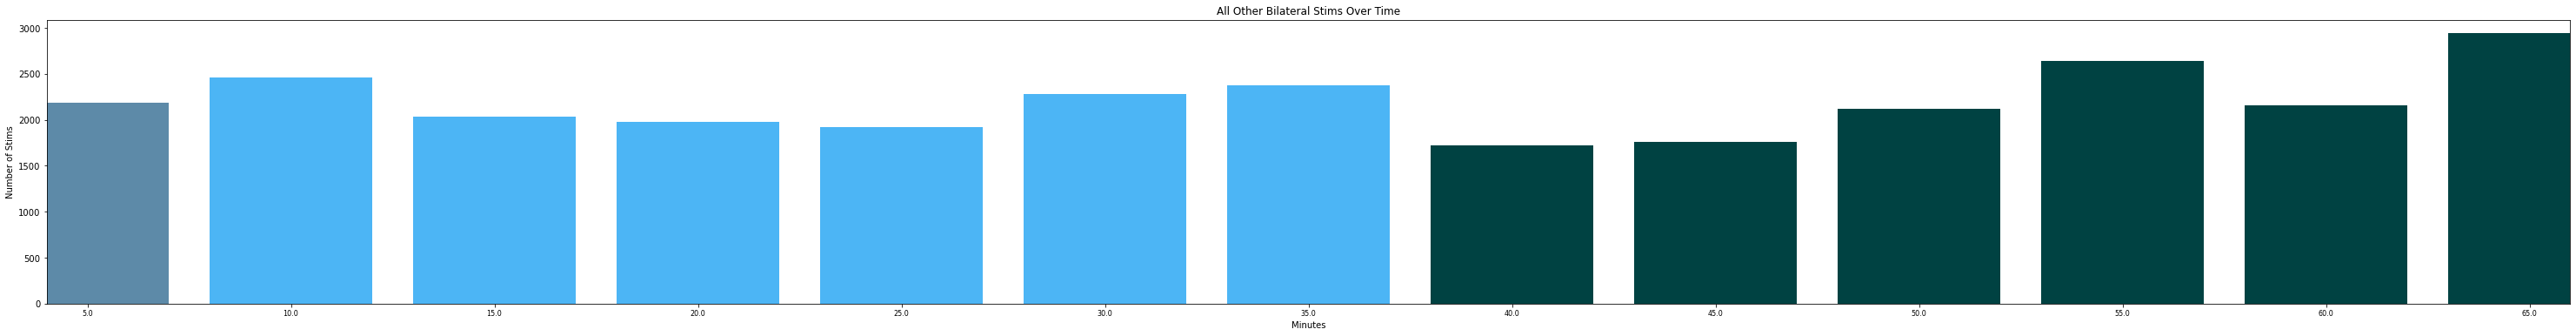

In [86]:
# Behavior mapping dictionary
behavior_mapping = {
    0: "Left Turn ",
    1: "Right Turn ",
    2: "Locomotion ",
    3: "Face Groom ",
    4: "All Other Groom ",
    5: "All Other "
}

# List of behaviors you want to analyze
behaviors_to_analyze = [0, 1, 2, 3, 4, 5]  # Add all behavior codes

# Initialize an empty dictionary to store filtered data for each behavior
filtered_data_by_behavior = {}

# Check if the user wants to change the time increment
change_time_increment = input("Do you want to change the time increment? (y/n): ")

if change_time_increment.lower() == "y":
    while True:
        try:
            time_interval = float(input("Enter the time interval (in deciseconds): "))
            break
        except ValueError:
            print("Invalid input. Please enter a numeric value.")

    time_interval_start = int(time_interval * 600)
    time_increase = int(time_interval * 600)
else:
        time_interval_start = 3000
        time_increase = 3000
        time_interval = 5

# Loop through each behavior
for behavior_code in behaviors_to_analyze:
    behavior_of_interest = behavior_mapping.get(behavior_code, "Unknown Behavior")
    print(f"Analyzing behavior: {behavior_of_interest}")

    required_first_element = behavior_code
    
    # Filter the tuples based on the required first element value and other conditions
    filtered_taab = [(behavior, duration, time) for behavior, duration, time in time_array_and_behavior if behavior == required_first_element and duration >= 3]
    
    # Store the filtered data in the dictionary using the behavior code as the key
    filtered_data_by_behavior[behavior_code] = filtered_taab

# Print the filtered data for each behavior
for behavior_code, filtered_taab in filtered_data_by_behavior.items():
    behavior_name = behavior_mapping.get(behavior_code, "Unknown Behavior")
    print(f"Filtered data for {behavior_name}:")
    print(filtered_taab)
    print("--------------")
    
binned_elements = []
current_bin = []
last_interval = None

for x in filtered_taab:
    if x[2] <= time_interval_start:
        current_bin.append(x[1])
    else:
        while x[2] > time_interval_start:
            if current_bin:
                binned_elements.append((time_interval_start, current_bin))
                current_bin = []  # Clear the current_bin after appending it
            else:
                binned_elements.append((time_interval_start, [0]))
            last_interval = time_interval_start

            time_interval_start += time_increase

            if x[2] <= time_interval_start:
                break

        current_bin.append(x[1])

# Append the last time interval with elements or zero
if current_bin:
    binned_elements.append((time_interval_start, current_bin))
else:
    binned_elements.append((time_interval_start, [0]))

# Print the time start intervals and their elements
#for interval, elements in binned_elements:
#    print("Interval:", interval)
#    print("Elements:", elements)
#    print()


# Count the stims in each bin   
interval_counts_1 = [sum(elements) for interval,elements in binned_elements]
#print(interval_counts_1)

stimulation_stim_count = sum([sum(elements) for interval, elements in binned_elements if 3000 < interval <= 21000])

print('Number Of',behavior_of_interest,'in 30 min Stimulation Block:', stimulation_stim_count)



interval_counts = [((index * time_interval) + time_interval,count) for index,count in enumerate(interval_counts_1)]
#print(interval_counts)

# Calculate the bar width based on the time interval
bar_width = time_interval * 0.8

# Increase the figure size
plt.figure(figsize=((len(interval_counts) * bar_width), 6))

# Plotting the bar graph
x_values = [interval[0] for interval in interval_counts]
y_values = [interval[1] for interval in interval_counts]
# Limit x-axis value to 65
#x_values = [min(x, ((int(length_of_session))/600)) for x in x_values]

# Create a bar chart with custom colors and adjusted bar width
color_base = '#5d8aa8'
color_stim = '#4cb5f5'
color_post = '#004242'

color_map = []
for interval in interval_counts:
    if interval[0] <= 5:
        color_map.append(color_base)
    elif 5 < interval[0] < 40:
        color_map.append(color_stim)
    else:
        color_map.append(color_post)

plt.bar(x_values, y_values, width=bar_width, color=color_map)

# Add labels and title
plt.xlabel('Minutes')
plt.ylabel('Number of Stims') 
title_text = behavior_of_interest + str(type_of_fiber_connection) + ' Stims Over Time'
if trial_type:
    title_text += ' ' + trial_type

plt.title(title_text)

# Set x-axis tick labels
if time_interval < 1:
    tick_positions = np.arange(5, ((math.ceil(length_of_session/600))+time_interval), 5)  # Tick labels starting from 5 and increasing by 5
    tick_labels = [str(int(time)) for time in tick_positions]
else:
    tick_positions = np.arange(time_interval, ((math.ceil(length_of_session/600))+time_interval), time_interval)  # Tick labels starting from time_interval and increasing by time_interval
    tick_labels = [f'{time:.1f}' for time in tick_positions]

plt.xticks(tick_positions, tick_labels, fontsize=8)
plt.xticks(tick_positions, tick_labels, fontsize=8)
plt.yticks(fontsize=10)

# Set the x-axis limits to only include the minimum and maximum x-axis values
x_min = min((x - 1) for x in x_values)
x_max = max((x +1) for x in x_values)
plt.xlim(x_min, x_max)

root = tk.Tk()
root.withdraw()
folder_path = filedialog.askdirectory()

if folder_path:
    # Save the histogram to the selected folder
    # Get the title as the file name
    title_text = plt.gca().get_title()
    file_name = title_text + '.png'
    save_path = os.path.join(folder_path, file_name)
    
    plt.savefig(save_path)
    # Show the plot
    plt.show()

In [ ]:
### Check if the user wants to change the time increment
change_time_increment = input("Do you want to change the time increment? (y/n): ")

if change_time_increment.lower() == "y":
    # Ask the user to input the time interval in minutes
    while True:
        try:
            time_interval = float(input("Enter the time interval (in minutes): "))
            break
        except ValueError:
            print("Invalid input. Please enter a numeric value.")

    # Set the time start and increase based on the user input
    time_interval_start = int(time_interval * 600)
    time_increase = int(time_interval * 600)
else:
    # Default time increment of 5 minutes
    time_interval_start = 3000
    time_increase = 3000
    time_interval = 5
    
# Define the required first element value
required_first_element = behavior_of_interest #sets the variable first element to be eqaul to the behavior of interest 

# Filter the tuples based on the required first element value
filtered_taab = [(sub_tuple[0], sub_tuple[1], sub_tuple[2]) for sub_tuple in time_array_and_behavior if sub_tuple[0] == required_first_element and sub_tuple[1]>=3]
#filtered_taab = [(sub_tuple[0], sub_tuple[1], sub_tuple[2]) for sub_tuple in time_array_and_behavior if sub_tuple[0] == required_first_element]
#####################3
####################
#print(filtered_taab)

binned_elements = []
current_bin = []
last_interval = None

for x in filtered_taab:
    if x[2] <= time_interval_start:
        current_bin.append(x[1])
    else:
        while x[2] > time_interval_start:
            if current_bin:
                binned_elements.append((time_interval_start, current_bin))
                current_bin = []  # Clear the current_bin after appending it
            else:
                binned_elements.append((time_interval_start, [0]))
            last_interval = time_interval_start

            time_interval_start += time_increase

            if x[2] <= time_interval_start:
                break

        current_bin.append(x[1])

# Append the last time interval with elements or zero
if current_bin:
    binned_elements.append((time_interval_start, current_bin))
else:
    binned_elements.append((time_interval_start, [0]))

# Print the time start intervals and their elements
#for interval, elements in binned_elements:
#    print("Interval:", interval)
#    print("Elements:", elements)
#    print()


# Count the stims in each bin   
interval_counts_1 = [sum(elements) for interval,elements in binned_elements]
#print(interval_counts_1)

stimulation_stim_count = sum([sum(elements) for interval, elements in binned_elements if 3000 < interval <= 21000])

print('Number Of',behavior_name_2,'in 30 min Stimulation Block:', stimulation_stim_count)



interval_counts = [((index * time_interval) + time_interval,count) for index,count in enumerate(interval_counts_1)]
#print(interval_counts)

# Calculate the bar width based on the time interval
bar_width = time_interval * 0.8

# Increase the figure size
plt.figure(figsize=((len(interval_counts) * bar_width), 6))

# Plotting the bar graph
x_values = [interval[0] for interval in interval_counts]
y_values = [interval[1] for interval in interval_counts]
# Limit x-axis value to 65
#x_values = [min(x, ((int(length_of_session))/600)) for x in x_values]

# Create a bar chart with custom colors and adjusted bar width
color_base = '#5d8aa8'
color_stim = '#4cb5f5'
color_post = '#004242'

color_map = []
for interval in interval_counts:
    if interval[0] <= 5:
        color_map.append(color_base)
    elif 5 < interval[0] < 40:
        color_map.append(color_stim)
    else:
        color_map.append(color_post)

plt.bar(x_values, y_values, width=bar_width, color=color_map)

# Add labels and title
plt.xlabel('Minutes')
plt.ylabel('Number of Stims') 
title_text = behavior_name_2 + str(type_of_fiber_connection) + ' Stims Over Time'
if trial_type:
    title_text += ' ' + trial_type

plt.title(title_text)

# Set x-axis tick labels
if time_interval < 1:
    tick_positions = np.arange(5, ((math.ceil(length_of_session/600))+time_interval), 5)  # Tick labels starting from 5 and increasing by 5
    tick_labels = [str(int(time)) for time in tick_positions]
else:
    tick_positions = np.arange(time_interval, ((math.ceil(length_of_session/600))+time_interval), time_interval)  # Tick labels starting from time_interval and increasing by time_interval
    tick_labels = [f'{time:.1f}' for time in tick_positions]

plt.xticks(tick_positions, tick_labels, fontsize=8)
plt.xticks(tick_positions, tick_labels, fontsize=8)
plt.yticks(fontsize=10)

# Set the x-axis limits to only include the minimum and maximum x-axis values
x_min = min((x - 1) for x in x_values)
x_max = max((x +1) for x in x_values)
plt.xlim(x_min, x_max)

root = tk.Tk()
root.withdraw()
folder_path = filedialog.askdirectory()

if folder_path:
    # Save the histogram to the selected folder
    # Get the title as the file name
    title_text = plt.gca().get_title()
    file_name = title_text + '.png'
    save_path = os.path.join(folder_path, file_name)
    
    plt.savefig(save_path)
    # Show the plot
    plt.show()

# Duration vs Time 

In [ ]:
# Calculate the average of each bin
interval_duration = [sum(elements) / len(elements) for interval, elements in binned_elements if any(element > 0 for element in elements)]
#print(interval_duration)
print('The average duration:',duration_average, ' seconds')

interval_duration = [sum(elements) / len(elements) for interval, elements in binned_elements]
#print(interval_duration)

#for i, (interval, _) in enumerate(binned_elements):
    #if any(element > 0 for element in binned_elements[i][1]):
        #print("Interval:", interval / 600)  # Divide by 600 to convert to minutes
        #print("Duration:", interval_duration[i])
        #print()

color_map = []
intervals = [interval / 600 for interval, _ in binned_elements]  # Divide by 600 to convert to minutes
for interval in intervals:
    if interval <= 5:
        color_map.append(color_base)
    elif 5 < interval < 40:
        color_map.append(color_stim)
    else:
        color_map.append(color_post)


plt.bar([(i * time_interval) + time_interval for i in range(len(interval_duration))], interval_duration, color=color_map)
max_duration = max(interval_duration)

# Add labels and title
plt.xlabel('Minutes')
plt.ylabel('Average Duration')
title_text = 'Average Duration of ' + behavior_name_2 + ' Over Time'

if trial_type:
    title_text += ' ' + trial_type

plt.title(title_text)

# Set the x-axis ticks
tick_positions = [i * 5 for i in range(len(interval_duration)+1)] # Added 1 to include the last tick
plt.xticks(tick_positions)

# Limit the x-axis range to 65 minutes
plt.xlim(0, 70)
# Set the y-axis limits to include 0
plt.ylim(bottom=0)
# Select the folder using a file dialog
root = tk.Tk()
root.withdraw()
folder_path = filedialog.askdirectory()

if folder_path:
    # Save the histogram to the selected folder
    # Get the title as the file name
    title_text = plt.gca().get_title()
    file_name = title_text + '.png'
    save_path = os.path.join(folder_path, file_name)
    
    plt.savefig(save_path)
    # Show the plot
    plt.show()

# Duration vs Time for 1 specific time period

# Select the specific interval you want to plot (e.g., first interval)
interval_index = 1

if interval_index < len(binned_elements):
    selected_interval = binned_elements[interval_index]

    # Generate x-axis values for the time window of 0-5 minutes
    x_values = np.linspace(5, 10, len(selected_interval)) #change the numbers here for whatever time frame youre look at currently it is 5 minutes to 10 minutes

    # Plot the selected interval
    plt.plot(x_values, selected_interval)

    # Add labels and title
    plt.xlabel('Time (minutes)')
    plt.ylabel('Duration')
    plt.title('Duration of Behavior ' + str(behavior_of_interest) + ' - Interval ' + str(interval_index + 1))
else:
    print("No binned elements in the selected interval.")

# Select the folder using a file dialog
root = tk.Tk()
root.withdraw()
folder_path = filedialog.askdirectory()

if folder_path:
    # Save the plot to the selected folder
    # Get the title as the file name
    title_text = plt.gca().get_title()
    file_name = title_text + '.png'
    save_path = os.path.join(folder_path, file_name)
    
    plt.savefig(save_path)

# Display the plot or message
plt.show()


# Bout vs Time 

In [ ]:
interval_lengths = [(interval, len(elements), elements) for interval, elements in binned_elements if all(element > 0 for element in elements)]
#for interval, length, elements in interval_lengths:
    #print("Interval:", interval)
    #print("Number of Bouts:", length)
    #print("Duration:", elements)
    #print()
stimulation_bout_total = sum(length for interval, length, _ in interval_lengths if 3000 < interval <= 21000)
total_bouts = sum(length for _, length, _ in interval_lengths)
Percentage_of_bouts_during_stim_block= round((stimulation_bout_total/total_bouts)*100)
print('Total Number Of Bouts:', total_bouts)
print('Total Bouts During Stimulation Period:', stimulation_bout_total)
#print('Percentage of Bouts occuring during Stimulation Block:',Percentage_of_bouts_during_stim_block,'%' )
intervals = [interval/600 for interval, _, _ in interval_lengths]
num_bouts = [length for _, length, _ in interval_lengths]

bar_width = 0.8  # Adjust this value to change the width of the bars

# Assuming you have the intervals and the corresponding number of bouts in separate lists
intervals = [interval / 600 for interval, _, _ in interval_lengths]
num_bouts = [length for _, length, _ in interval_lengths]


# Create a color map based on the intervals
color_map = []
for interval in intervals:
    if interval <= 5:
        color_map.append(color_base)  
    elif 5 < interval < 40:
        color_map.append(color_stim)  
    else:
        color_map.append(color_post)  

# Plotting the data as a bar plot with custom colors
plt.bar(intervals, num_bouts, width=bar_width, align='center', color=color_map)
# Set the labels and title
plt.xlabel('Minutes')
plt.ylabel('Bouts')
title_text = behavior_name_2 + type_of_fiber_connection + ' Bouts Over Time'

if trial_type:
    title_text += ' ' + trial_type

plt.title(title_text)

tick_positions = np.arange(5, 70, 5)
plt.xticks(tick_positions)

root = tk.Tk()
root.withdraw()
folder_path = filedialog.askdirectory()

if folder_path:
    # Save the histogram to the selected folder
    # Get the title as the file name
    title_text = plt.gca().get_title()
    file_name = title_text + '.png'
    save_path = os.path.join(folder_path, file_name)
    
    plt.savefig(save_path)
    # Show the plot
    plt.show()

In [ ]:
data_dict = {}
session_numbers = {}

# Iterate through each file in infiles
for file_path in infiles: # if taking from Z Drive 
    folders = (os.path.dirname(file_path)).split('/')
    print(folders)
    # Extract the mouse name from the file path
    mouse_name = folders[2].split('-')[0]
    # Extract the genotype from the file path
    genotype = folders[2].split('-')[1]
    # Extract the date from the file path
    date = folders[-1].split('-')[0]
#for file_path in infiles:   #if taking files from D drive
    #folders = (os.path.dirname(file_path)).split('/')
    #print(folders)
    # Extract the mouse name from the file path
    #mouse_name = folders[6].split('-')[0]
    # Extract the genotype from the file path
    #genotype = folders[6].split('-')[1]
    # Extract the date from the file path
    #date = folders[-1].split('-')[0]    
# Determine the session number for this mouse and stim behavior
    key = (mouse_name, behavior_name_2, type_of_fiber_connection)
    if key not in session_numbers:
        session_numbers[key] = 1
    else:
        session_numbers[key] += 1
    session_number = session_numbers[key]
    
    # Retrieve the relevant statistics from the dictionaries
    right_turn_bout_count = behavior_bouts.get("Right Turns", 0)
    right_turn_stim_count = behavior_duration_dict.get(1.0, 0)
    average_duration_right_turn = behavior_average_duration_dict.get(1.0, 0)
    right_turn_stim_30min = stimulation_count_dict.get(1.0, 0)
    
    loc_bout_count = behavior_bouts.get("Locomotion", 0)
    loc_stim_count = behavior_duration_dict.get(2.0, 0)
    average_duration_loc = behavior_average_duration_dict.get(2.0, 0)
    loc_stim_30min = stimulation_count_dict.get(2.0, 0)
    
    face_groom_bout_count = behavior_bouts.get("Face Groom", 0)
    face_groom_stim_count = behavior_duration_dict.get(3.0, 0)
    average_duration_face_groom = behavior_average_duration_dict.get(3.0, 0)
    face_groom_stim_30min = stimulation_count_dict.get(3.0, 0)
    
    all_other_groom_bout_count = behavior_bouts.get("All Other Groom", 0)
    all_other_groom_stim_count = behavior_duration_dict.get(4.0, 0)
    average_duration_all_other_groom = behavior_average_duration_dict.get(4.0, 0)
    all_other_groom_stim_30min = stimulation_count_dict.get(4.0, 0)
    
    all_other_bout_count = behavior_bouts.get("All Other", 0)
    all_other_stim_count = behavior_duration_dict.get(5.0, 0)
    average_duration_all_other = behavior_average_duration_dict.get(5.0, 0)
    all_other_stim_30min = stimulation_count_dict.get(5.0, 0)
    
    mouse_data = {
        "Mouse": mouse_name,
        "Genotype": genotype,
        "Date": date,
        "Stim Behavior": behavior_name_2,
        "Sham y/n": sham_session,  
        "Session Number": session_number,
        "Fiber Connection": type_of_fiber_connection,
        "Right-turn Bout Count": right_turn_bout_count,
        "Right-turn Stim Count": right_turn_stim_count,
        "Average Duration of right-turn": average_duration_right_turn,
        "Right-turn Stim in 30 min period": right_turn_stim_30min,
        "Locomotion Bout Count": loc_bout_count,
        "Locomotion Stim Count": loc_stim_count,
        "Average Duration of Locomotion": average_duration_loc,
        "Locomotion Stim in 30 min period": loc_stim_30min,
        "Face-groom Bout Count": face_groom_bout_count,
        "Face-groom Stim Count": face_groom_stim_count,
        "Average Duration of Face-groom": average_duration_face_groom,
        "Face-groom Stim in 30 min period": face_groom_stim_30min,
        "All Other Groom Bout Count": all_other_groom_bout_count,
        "All Other Groom Stim Count": all_other_groom_stim_count,
        "Average Duration of All Other Groom": average_duration_all_other_groom,
        "All Other Groom Stim in 30 min period": all_other_groom_stim_30min,
        "All Other Bout Count": all_other_bout_count,
        "All Other Stim Count": all_other_stim_count,
        "Average Duration of All Other": average_duration_all_other,
        "All Other Stim in 30 min period": all_other_stim_30min,
    }

    data_dict[mouse_name]=mouse_data

# Specify the file path for the CSV file
csv_file_path = "Z:/KayCei/PostHocAnalysis.csv"

# Define the headers for the CSV file
headers = ["Mouse", "Genotype", "Date", "Stim Behavior", "Sham y/n", "Session Number", "Fiber Connection",
           "Right-turn Bout Count", "Right-turn Stim Count", "Average Duration of right-turn",
           "Right-turn Stim in 30 min period", "Locomotion Bout Count", "Locomotion Stim Count",
           "Average Duration of Locomotion", "Locomotion Stim in 30 min period", "Face-groom Bout Count",
           "Face-groom Stim Count", "Average Duration of Face-groom", "Face-groom Stim in 30 min period",
           "All Other Groom Bout Count", "All Other Groom Stim Count", "Average Duration of All Other Groom",
           "All Other Groom Stim in 30 min period", "All Other Bout Count", "All Other Stim Count",
           "Average Duration of All Other", "All Other Stim in 30 min period"]

if os.path.exists(csv_file_path):
    # Keep track of existing entries in the CSV to avoid duplicates
    existing_entries = set()
    entry_key2_session_numbers = {}

    # Read existing data from the CSV and add it to the set
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            entry_key = (row["Mouse"], row["Stim Behavior"], row["Fiber Connection"], row["Date"])
            entry_key2 = (row["Mouse"], row["Stim Behavior"], row["Fiber Connection"], row["Sham y/n"])
            existing_entries.add(entry_key)
            entry_key2_session_numbers[entry_key2] = int(row["Session Number"])

# Define the set before the if statement
else:
    existing_entries = set()
    entry_key2_session_numbers = {}

# Write the data from data_dict to the CSV file (in append mode 'a')
with open(csv_file_path, 'a', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=headers)

    # Check if the file is empty, if so, write the header
    if csvfile.tell() == 0:
        writer.writeheader()

    # Write the data for each mouse
    for mouse_data in data_dict.values():
        entry_key = (mouse_data["Mouse"], mouse_data["Stim Behavior"], mouse_data["Fiber Connection"], mouse_data["Sham y/n"])
        
        # Check if the entry already exists in the CSV, if not, write it
        if entry_key not in existing_entries:
            # Get the session number based on entry_key
            session_number = entry_key2_session_numbers.get(entry_key, 0) + 1
            mouse_data["Session Number"] = session_number
            writer.writerow(mouse_data)
            existing_entries.add(entry_key)
            entry_key2_session_numbers[entry_key] = session_number
            print("Entry added Sucessfully:", entry_key)
        else:
            print("Entry already exists in the CSV:", entry_key)